# Investigate S1 Data

Look into S3 buckets and query data we want to use in our ML process. This is an exploratory notebook where we want to find out how certain features are working, how they perform and get a general feel for the data. We want to answer the following questions:

 - How to access S1 data
 - How to geo-reference it with our Ramsar shapes
 - Statistical makeup of S1 data

In [2]:
import rioxarray
import rasterio
import numpy as np
from pathlib import Path

from shapely.geometry import Polygon

%matplotlib inline

In [3]:
S1_2021_PATH_LIST = Path("/shared/sentinel-1/paths-west-AT-2021.txt")

## Look at file list of general area

This file list has been generated using: https://finder.creodias.eu/

In [4]:
s1_west_at_2021_paths = S1_2021_PATH_LIST.read_text().splitlines()
s1_west_at_2021_paths[:3]

['/eodata/Sentinel-1/SAR/GRD/2021/12/30/S1A_IW_GRDH_1SDV_20211230T165946_20211230T170011_041241_04E6B7_77BD.SAFE',
 '/eodata/Sentinel-1/SAR/GRD/2021/12/30/S1A_IW_GRDH_1SDV_20211230T165921_20211230T165946_041241_04E6B7_8B2C.SAFE',
 '/eodata/Sentinel-1/SAR/GRD/2021/12/30/S1A_IW_GRDH_1SDV_20211230T165856_20211230T165921_041241_04E6B7_DF3B.SAFE']

A selection of tiff files in the vicinity of ramsar areas, to see how we can test for overlaps

In [5]:
s1_tiff = (Path(s1_west_at_2021_paths[0]) / "measurement/s1a-iw-grd-vv-20211230t165946-20211230t170011-041241-04e6b7-001.tiff").as_posix()
s1_overlapping_tiff = "/eodata/Sentinel-1/SAR/GRD/2021/12/20/S1A_IW_GRDH_1SDV_20211220T164308_20211220T164333_041095_04E1D3_06AA.SAFE/measurement/s1a-iw-grd-vh-20211220t164308-20211220t164333-041095-04e1d3-002.tiff"
s1_other_overlapping_tiff = "/eodata/Sentinel-1/SAR/GRD/2021/12/12/S1B_IW_GRDH_1SDV_20211212T165838_20211212T165903_029995_0394BB_A44F.SAFE/measurement/s1b-iw-grd-vh-20211212t165838-20211212t165903-029995-0394bb-002.tiff"

## Load S1 Tiff Files

Also making sure they are properly geo-referenced. For this we need to calculate the transformation using the provided ground control points, as the transform is not part of the GeoTiff. See this issue of rioxarray on why it is done this way:
- https://github.com/corteva/rioxarray/issues/339#issuecomment-853877629

In [6]:
from rasterio.enums import Resampling
from rasterio.vrt import WarpedVRT

with rasterio.open(s1_other_overlapping_tiff) as src:
    gcps, crs = src.get_gcps()
    with WarpedVRT(src, resampling=Resampling.bilinear) as vrt:
        rds = rioxarray.open_rasterio(vrt)
rds.rio.bounds()

(11.14906467170389, 46.62118174717388, 15.055245103226198, 48.52427789290543)

### Analyse S1 Data

Investigate the statistical makeup of S1 data. We look at quantiles to figure out good clamping values to reduce noise.
Looking at the quantiles values between 0 and 200 seem to contain most of the information.

In [12]:
rds.quantile([0, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 1.0])

<xarray.DataArray (quantile: 9)>
array([    0.,     0.,     0.,     0.,    57.,    87.,   120.,   216.,
       10268.])
Coordinates:
  * quantile  (quantile) float64 0.0 0.01 0.1 0.25 0.5 0.75 0.9 0.99 1.0

## Loading Ramsar Data

We use geopandas to load Ramsar geometry because it also provides us with names to identify the polygon easily

In [29]:
ramsar_shp_files = "/shared/ramsar/RAMSAR_AT_01.shp"

In [30]:
import geopandas as pd

ramsar_df = pd.read_file(ramsar_shp_files)

In [31]:
ramsar_df

,v_idris,ramsarid,officialna,iso3,country_en,area_off,geometry
0,48325332,275,Rheindelta,AUT,Austria,2065.0,"POLYGON ((9.65359 47.52180, 9.65386 47.52135, ..."
1,54483826,2137,Güssing Fishponds,AUT,Austria,148.0,"MULTIPOLYGON (((16.30265 47.04916, 16.30241 47..."
2,54485912,2146,Wilder Kaiser,AUT,Austria,3781.0,"MULTIPOLYGON (((12.37123 47.52823, 12.37144 47..."
3,54481476,2208,Upper Drava River,AUT,Austria,1029.0,"MULTIPOLYGON (((13.35642 46.83327, 13.35657 46..."
4,45261037,272,Donau-March-Thaya-Auen,AUT,Austria,36090.0,"POLYGON ((16.92747 48.63919, 16.92745 48.63919..."
5,56613912,1489,Bayerische Wildalm and Wildalmfilz,AUT,Austria,133.0,"POLYGON ((11.79925 47.58664, 11.79937 47.58637..."
6,54494192,1979,Autertal - St. Lorenzener Hochmoor,AUT,Austria,48.0,"POLYGON ((13.91654 46.86870, 13.91689 46.86862..."


In [ ]:
polygon = ramsar_df['geometry'].iloc[2]
polygon

### Test Geometry Intersection

To reduce the data load we only want to process data within our regions of interest

In [33]:
from shapely.geometry import box

box(*rds.rio.bounds()).intersects(polygon)

True

In [34]:
rds.rio.set_crs(crs)
clipped = rds.rio.clip_box(*polygon.bounds)

In [35]:
clip_array = np.asarray(clipped)

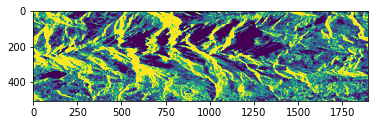

In [36]:
import matplotlib.pyplot as plt

plt.imshow(clip_array[0], vmin=51, vmax=130)

## Test Array Coarsening

Testing how xarray coarsening works and if it behaves how we'd expect. Also looking again at the statistical makeup of the data, to see how much coarsening reduces noise.

In [37]:
coarsed = clipped.coarsen(x=10, boundary='trim').mean().coarsen(y=10, boundary='trim').mean()

In [38]:
coarsed.quantile([0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0])

<xarray.DataArray (quantile: 7)>
array([ 35.43  ,  55.029 ,  69.93  ,  88.165 , 110.4375, 140.742 ,
       444.27  ])
Coordinates:
  * quantile  (quantile) float64 0.0 0.1 0.25 0.5 0.75 0.9 1.0

In [21]:
coarsed_a = np.asarray(coarsed)

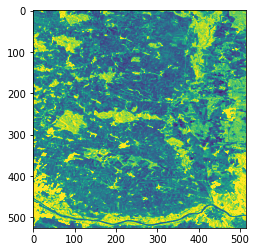

In [24]:
plt.imshow(coarsed_a[0], vmin=32, vmax=130)